In [21]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import jax.scipy as jsp 
plt.rc("figure", figsize=[6,6], dpi=150, facecolor='w')
import numpy as np

rng = np.random.default_rng(4)

In [22]:
@jax.vmap
def TT(s):
    theta = jnp.arctan(s[1]/s[0])
    r = ((s[0]**2 + s[1]**2)**.5)/2
    T = jnp.array([[jnp.cos(theta), jnp.sin(theta)],[-jnp.sin(theta), jnp.cos(theta)]])@jnp.array([[1/r,0],[0,1]])
    return T@T.T

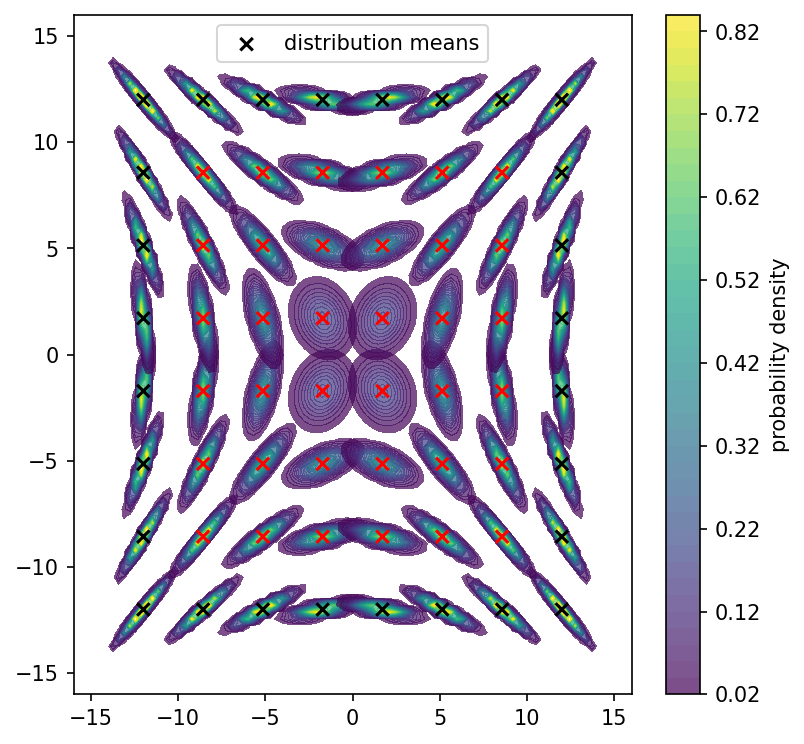

In [36]:

def xy_pairs(nx, ny, span):
    size = nx, ny
    x_grid = jnp.linspace(-span, span, nx)
    y_grid = jnp.linspace(-span, span, ny)
    xx, yy = jnp.meshgrid(x_grid, y_grid)
    return jnp.hstack((xx.reshape(-1,1), yy.reshape(-1,1))), size, xx, yy

val = 16
xy_pairs_eval, grid_size, xx, yy = xy_pairs(100,100, val)
num_means = 8
means, g, xx2, yy2 = xy_pairs(num_means,num_means, 12)
covs = TT(means)

def gaussian_2d_pdf(eval_points, mean, cov):
    return jsp.stats.multivariate_normal.pdf(eval_points, mean=mean, cov=cov)

vmapped_pdf = jax.vmap(gaussian_2d_pdf, in_axes=(None, 0, 0))

# covs = jnp.array([[[1, 0],[3,3]] for _ in means])
pdfs = vmapped_pdf(xy_pairs_eval, means, covs).reshape(len(means), *grid_size) 

fig, ax = plt.subplots()

step = 0.02
m = jnp.amax(pdfs[len(pdfs) // 2])
levels = jnp.arange(0.0, m, step) + step
for pdf in pdfs:
    a = ax.contourf(xx, yy, pdf,  alpha=0.7, cmap="viridis",levels=levels)
temp = means.reshape(num_means, num_means, 2)[1:-1, 1:-1, :].reshape(-1, 2).tolist()
ax.scatter(xx2, yy2, marker='x', c=['r' if x in temp else 'k' for x in means.tolist()], label ="distribution means")
plt.colorbar(a, ax=ax, label="probability density")
ax.legend(loc="upper center", fancybox=True)

In [25]:
from jax.random import multivariate_normal, PRNGKey

@jax.vmap
def samples(mean, cov):
    return multivariate_normal(PRNGKey(0), mean, cov, shape=(10000,))

samps = samples(means, covs)
samps.shape

(64, 10000, 2)

In [27]:
a = rng.random(size=(8,8))[:]
a

array([[0.30735792, 0.80704794, 0.10747159, 0.39218891, 0.87643382,
        0.91764241, 0.23347627, 0.07872015],
       [0.7877275 , 0.62177807, 0.23750482, 0.50589319, 0.07141822,
        0.70008732, 0.52672546, 0.70464786],
       [0.08816937, 0.64481502, 0.37033588, 0.49930857, 0.3354825 ,
        0.63408653, 0.56826094, 0.61711476],
       [0.06337962, 0.2251416 , 0.07190456, 0.38329785, 0.48100849,
        0.11234194, 0.66758908, 0.48735676],
       [0.50032971, 0.59746584, 0.9348784 , 0.58886497, 0.09348256,
        0.14646923, 0.69389313, 0.32261722],
       [0.75528723, 0.51063881, 0.37968855, 0.73944869, 0.18298081,
        0.2848126 , 0.29194082, 0.41531804],
       [0.90711385, 0.81253963, 0.82160339, 0.63114986, 0.00821382,
        0.28613305, 0.5017994 , 0.89845475],
       [0.36377843, 0.55055946, 0.84854484, 0.34140649, 0.74807484,
        0.59502721, 0.52533189, 0.62979092]])

In [33]:
a[1:-1,1:-1].shape

(6, 6)

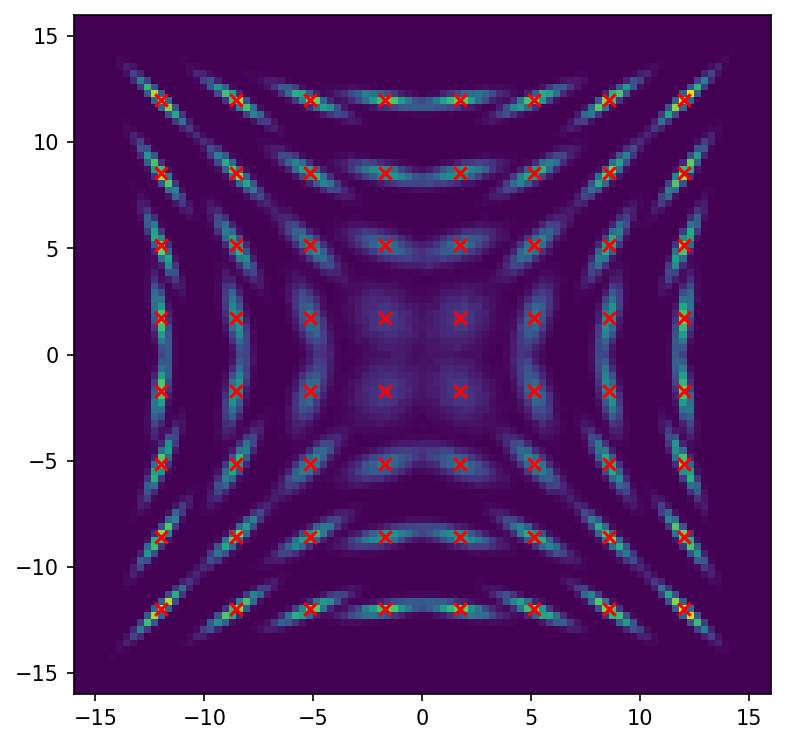

In [20]:
from plothelp import autogrid
fig, ax = plt.subplots()

bins = np.linspace(-val, val, 100), np.linspace(-val, val, 100)


def plot(ax, s, i):
    x, y = s[:,0], s[:,1]
    ax.hist2d(x,y, density=True, bins=bins)
    ax.set_xlim((-val,val))
    ax.set_ylim((-val,val))

data = jnp.concatenate(samps)
plot(ax, data, 0)
ax.scatter(xx2, yy2, marker='x', c='r', label ="distribution means")